<a href="https://colab.research.google.com/github/abiolahenrys/Big-Data-analysis-video_section-/blob/main/Video_analysis_Global_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




```
# Importing Libraries
```



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import seaborn as sns
from scipy.spatial.distance import euclidean



```
# Setting the Paths
```



In [5]:
def load_all_videos_data(base_path):
    # Load data from all videos
    features_path = os.path.join(base_path, 'Features')
    visual_files = [f for f in os.listdir(features_path)
                   if f.endswith('_visual.pkl')]

    video_names = [f.replace('_visual.pkl', '') for f in visual_files]

    # Store everything here
    all_visual_data = []
    all_audio_data = []
    all_speech_data = []
    all_face_clusters = {'unique_face_count': 0, 'face_ids_by_frame': [], 'unique_face_embeddings': []}

    video_info = []
    frame_counter = 0
    speaker_counter = 0

    for video in video_names:
        # Load the three data files for each video
        visual_path = os.path.join(features_path, f'{video}_visual.pkl')
        audio_path = os.path.join(features_path, f'{video}_audio.pkl')
        speech_path = os.path.join(features_path, f'{video}_speech.pkl')

        visual_data = pd.read_pickle(visual_path)
        audio_data = pd.read_pickle(audio_path)
        speech_data = pd.read_pickle(speech_path)

        # Add video name and frame numbers
        visual_data['video_name'] = video
        visual_data['original_frame_idx'] = visual_data.index
        visual_data['global_frame_idx'] = visual_data.index + frame_counter

        audio_data['video_name'] = video
        audio_data['global_timestamp'] = audio_data['time stamp'] + frame_counter

        speech_data['video_name'] = video
        speech_data['global_timestamp'] = speech_data['timestamp'] + frame_counter

        # Do face clustering for this video
        video_faces = cluster_faces_single_video(visual_data, speaker_counter)

        # Update the global face data
        all_face_clusters['unique_face_count'] += video_faces['unique_face_count']
        all_face_clusters['face_ids_by_frame'].extend(video_faces['face_ids_by_frame'])
        all_face_clusters['unique_face_embeddings'].extend(video_faces['unique_face_embeddings'])

        # Keep track of video info
        video_info.append({
            'video_name': video,
            'frame_count': len(visual_data),
            'start_global_frame': frame_counter,
            'end_global_frame': frame_counter + len(visual_data) - 1,
            'start_speaker_id': speaker_counter,
            'end_speaker_id': speaker_counter + video_faces['unique_face_count'] - 1
        })

        all_visual_data.append(visual_data)
        all_audio_data.append(audio_data)
        all_speech_data.append(speech_data)

        frame_counter += len(visual_data)
        speaker_counter += video_faces['unique_face_count']

    # Put everything together
    combined_visual = pd.concat(all_visual_data, ignore_index=True)
    combined_audio = pd.concat(all_audio_data, ignore_index=True)
    combined_speech = pd.concat(all_speech_data, ignore_index=True)

    return {
        'visual_data': combined_visual,
        'audio_data': combined_audio,
        'speech_data': combined_speech,
        'face_clusters': all_face_clusters,
        'video_info': pd.DataFrame(video_info),
        'total_videos': len(video_names)
    }

def cluster_faces_single_video(visual_data, start_speaker_id, threshold=0.4):
    # Cluster faces in one video
    unique_embeddings = []
    face_ids_per_frame = []
    next_speaker_id = start_speaker_id

    for idx, row in visual_data.iterrows():
        frame_faces = []

        if not row['fer']:  # no faces detected
            face_ids_per_frame.append([])
            continue

        for face in row['fer']:
            face_embedding = np.array(face['embedding'])
            found_match = False

            # Check if this face matches any we've seen before
            for i, known_embedding in enumerate(unique_embeddings):
                distance = np.linalg.norm(face_embedding - known_embedding)
                if distance < threshold:
                    frame_faces.append(start_speaker_id + i)
                    found_match = True
                    break

            # New face
            if not found_match:
                unique_embeddings.append(face_embedding)
                frame_faces.append(next_speaker_id)
                next_speaker_id += 1

        face_ids_per_frame.append(frame_faces)

    return {
        'unique_face_count': len(unique_embeddings),
        'unique_face_embeddings': unique_embeddings,
        'face_ids_by_frame': face_ids_per_frame
    }

# Load the data
base_path = '/content/drive/MyDrive/PBD_Projecto/Project_Data'
global_data = load_all_videos_data(base_path)

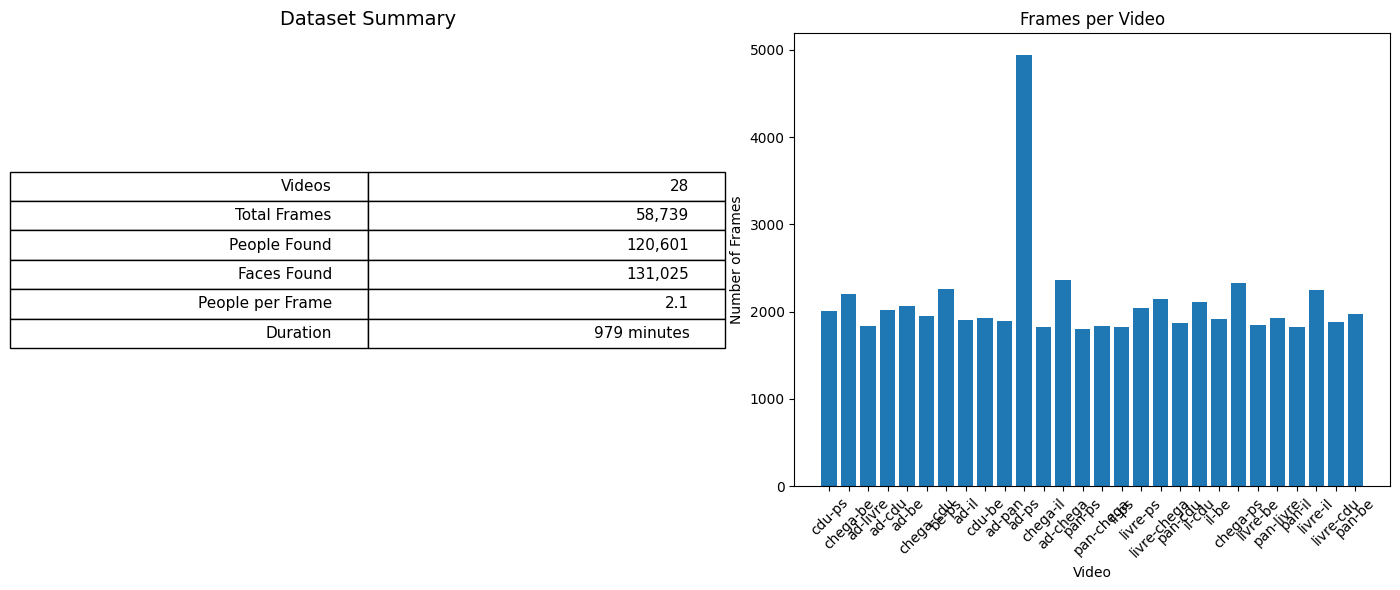

In [ ]:
def show_dataset_overview(global_data):
    visual_data = global_data['visual_data']

    # Count basic stuff
    total_frames = len(visual_data)
    total_videos = global_data['total_videos']

    # Count people and faces in all frames
    people_count = 0
    faces_count = 0

    for idx, row in visual_data.iterrows():
        # Count people detections
        for detection in row['detections']:
            if detection[4] == 'person':
                people_count += 1

        # Count faces
        if row['fer']:
            faces_count += len(row['fer'])

    # Make two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Left plot: Basic stats table
    ax1.axis('off')
    stats = [
        ["Videos", f"{total_videos}"],
        ["Total Frames", f"{total_frames:,}"],
        ["People Found", f"{people_count:,}"],
        ["Faces Found", f"{faces_count:,}"],
        ["People per Frame", f"{people_count/total_frames:.1f}"],
        ["Duration", f"{total_frames/60:.0f} minutes"]
    ]

    table = ax1.table(cellText=stats, loc='center')
    table.set_fontsize(11)
    table.scale(1.2, 1.8)
    ax1.set_title("Dataset Summary", fontsize=14)

    # Right plot: Compare videos
    video_names = []
    video_frames = []

    for idx, video in global_data['video_info'].iterrows():
        video_data = visual_data[visual_data['video_name'] == video['video_name']]
        video_names.append(video['video_name'])
        video_frames.append(len(video_data))

    ax2.bar(video_names, video_frames)
    ax2.set_title("Frames per Video")
    ax2.set_xlabel("Video")
    ax2.set_ylabel("Number of Frames")
    plt.setp(ax2.get_xticklabels(), rotation=45)

    plt.tight_layout()
    return fig

# Show the overview
overview_fig = show_dataset_overview(global_data)
plt.show()

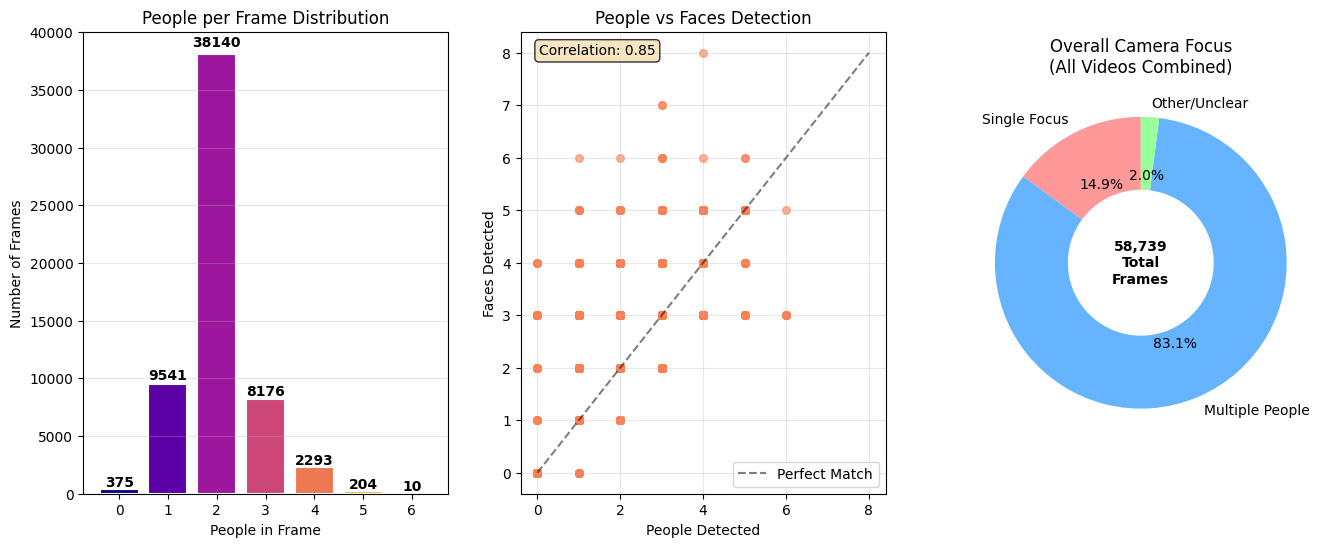

<Figure size 640x480 with 0 Axes>

In [ ]:
def show_people_frequency(global_data):
    visual_data = global_data['visual_data']

    # Count people and faces in each frame
    people_counts = []
    faces_counts = []

    for idx, row in visual_data.iterrows():
        # Count people in this frame
        people_in_frame = 0
        for detection in row['detections']:
            if detection[4] == 'person':
                people_in_frame += 1

        # Count faces in this frame
        faces_in_frame = len(row['fer']) if row['fer'] else 0

        people_counts.append(people_in_frame)
        faces_counts.append(faces_in_frame)

    # Make plots with better styling
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

    # Plot 1: People distribution as clean bar chart with better styling
    people_dist = pd.Series(people_counts).value_counts().sort_index()

    # Use gradient colors
    colors1 = plt.cm.plasma(np.linspace(0, 1, len(people_dist)))

    bars = ax1.bar(people_dist.index, people_dist.values, color=colors1,
                   edgecolor='white', linewidth=1.5)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    ax1.set_xlabel('People in Frame')
    ax1.set_ylabel('Number of Frames')
    ax1.set_title('People per Frame Distribution')
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: People vs Faces scatter plot to show relationship
    plt.figure()
    ax2.scatter(people_counts, faces_counts, alpha=0.6, color='coral', s=30)
    ax2.set_xlabel('People Detected')
    ax2.set_ylabel('Faces Detected')
    ax2.set_title('People vs Faces Detection')
    ax2.grid(True, alpha=0.3)

    # Add diagonal line to show perfect correlation
    max_val = max(max(people_counts), max(faces_counts))
    ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect Match')
    ax2.legend()

    # Add correlation text
    correlation = np.corrcoef(people_counts, faces_counts)[0,1]
    ax2.text(0.05, 0.95, f'Correlation: {correlation:.2f}',
            transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

    # Plot 3: Camera focus as donut chart for each video
    videos = global_data['video_info']

    # Calculate overall focus statistics
    all_single = 0
    all_multiple = 0
    all_other = 0

    for idx, video in videos.iterrows():
        video_frames = visual_data[visual_data['video_name'] == video['video_name']]

        for _, frame in video_frames.iterrows():
            people = sum(1 for d in frame['detections'] if d[4] == 'person')
            faces = len(frame['fer']) if frame['fer'] else 0

            if people == 1 and faces == 1:
                all_single += 1
            elif people >= 2 and faces >= 2:
                all_multiple += 1
            else:
                all_other += 1

    # Create donut chart
    sizes = [all_single, all_multiple, all_other]
    labels = ['Single Focus', 'Multiple People', 'Other/Unclear']
    colors3 = ['#ff9999', '#66b3ff', '#99ff99']

    wedges, texts, autotexts = ax3.pie(sizes, labels=labels, autopct='%1.1f%%',
                                      colors=colors3, startangle=90,
                                      wedgeprops=dict(width=0.5))

    # Add center circle for donut effect
    centre_circle = plt.Circle((0,0), 0.3, fc='white')
    ax3.add_artist(centre_circle)
    ax3.set_title('Overall Camera Focus\n(All Videos Combined)')

    # Add total frames in center
    total_frames = len(visual_data)
    ax3.text(0, 0, f'{total_frames:,}\nTotal\nFrames', ha='center', va='center',
            fontsize=10, weight='bold')

    plt.tight_layout()
    return fig

# Show the analysis
people_fig = show_people_frequency(global_data)
plt.show()

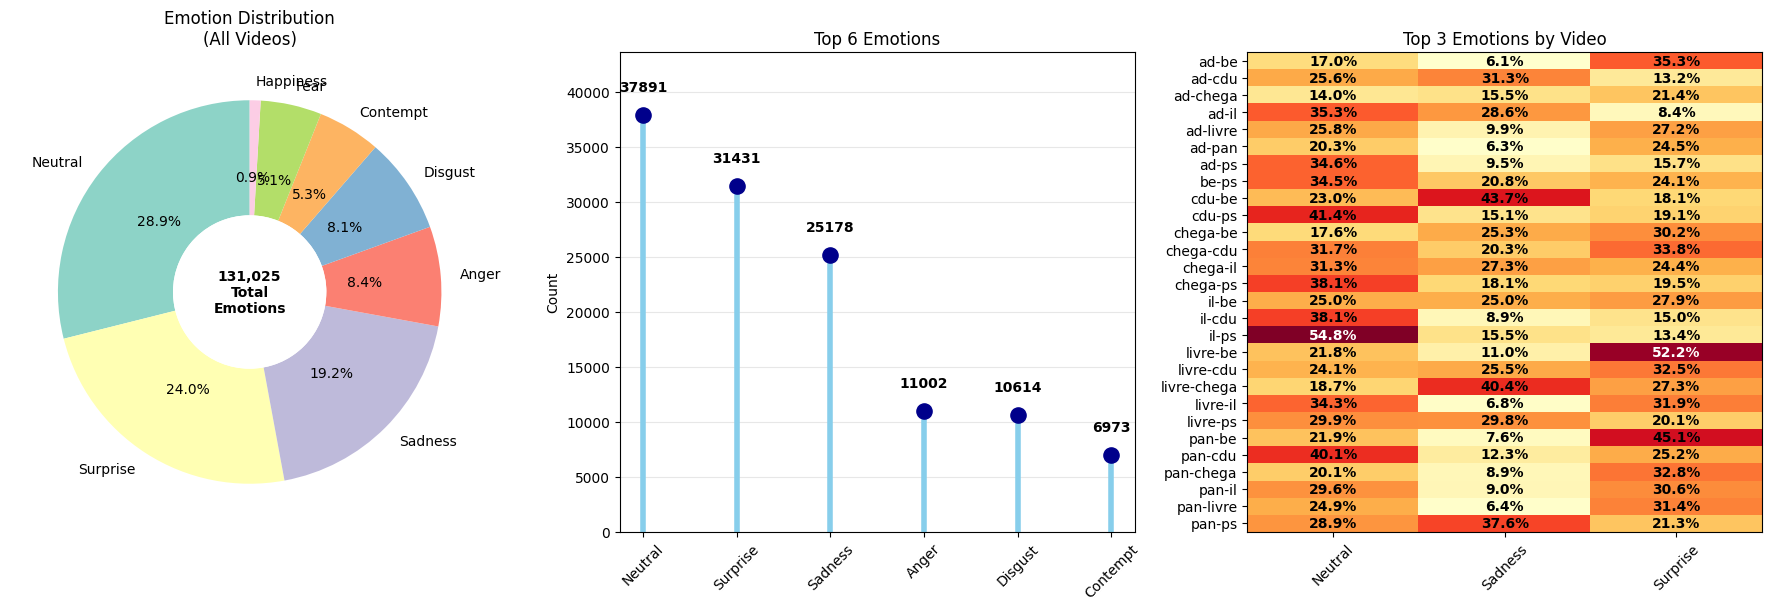

In [ ]:
def show_emotions_analysis(global_data):
    visual_data = global_data['visual_data']

    # Collect all emotions from all videos
    all_emotions = []

    for idx, row in visual_data.iterrows():
        if row['fer']:
            for face in row['fer']:
                all_emotions.append(face['emotion'])

    # Count emotions
    emotion_counts = pd.Series(all_emotions).value_counts()

    # Make three different plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Donut chart for overall emotions
    colors = plt.cm.Set3(range(len(emotion_counts)))

    wedges, texts, autotexts = ax1.pie(emotion_counts.values, labels=emotion_counts.index,
                                      autopct='%1.1f%%', colors=colors, startangle=90,
                                      wedgeprops=dict(width=0.6))

    # Add center circle for donut effect
    centre_circle = plt.Circle((0,0), 0.4, fc='white')
    ax1.add_artist(centre_circle)
    ax1.set_title('Emotion Distribution\n(All Videos)')

    # Add total count in center
    total_emotions = len(all_emotions)
    ax1.text(0, 0, f'{total_emotions:,}\nTotal\nEmotions', ha='center', va='center',
            fontsize=10, weight='bold')

    # Plot 2: Vertical lollipop chart for top emotions (better spacing)
    top6_emotions = emotion_counts.head(6)
    x_pos = range(len(top6_emotions))

    # Create vertical lollipop chart
    ax2.vlines(x_pos, 0, top6_emotions.values, colors='skyblue', linewidth=4)
    ax2.scatter(x_pos, top6_emotions.values, s=120, color='darkblue', zorder=3)

    # Add value labels above the dots with better spacing
    for i, (emotion, count) in enumerate(top6_emotions.items()):
        ax2.text(i, count + max(top6_emotions.values) * 0.05, f'{count}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(top6_emotions.index, rotation=45)
    ax2.set_ylabel('Count')
    ax2.set_title('Top 6 Emotions')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, max(top6_emotions.values) * 1.15)

    # Plot 3: Emotion timeline across videos
    videos = global_data['video_info']

    # Calculate emotion percentages for each video
    video_emotion_data = []
    for idx, video in videos.iterrows():
        video_frames = visual_data[visual_data['video_name'] == video['video_name']]

        video_emotions = []
        for _, frame in video_frames.iterrows():
            if frame['fer']:
                for face in frame['fer']:
                    video_emotions.append(face['emotion'])

        if video_emotions:
            video_emotion_counts = pd.Series(video_emotions).value_counts()
            total_video_emotions = len(video_emotions)

            # Get percentages for top 3 emotions
            top3_emotions = emotion_counts.head(3).index
            for emotion in top3_emotions:
                pct = (video_emotion_counts.get(emotion, 0) / total_video_emotions) * 100
                video_emotion_data.append({
                    'video': video['video_name'],
                    'emotion': emotion,
                    'percentage': pct
                })

    # Create heatmap-style visualization
    if video_emotion_data:
        emotion_df = pd.DataFrame(video_emotion_data)
        pivot_df = emotion_df.pivot(index='video', columns='emotion', values='percentage')

        # Create heatmap
        im = ax3.imshow(pivot_df.values, cmap='YlOrRd', aspect='auto')

        # Set ticks and labels
        ax3.set_xticks(range(len(pivot_df.columns)))
        ax3.set_xticklabels(pivot_df.columns)
        ax3.set_yticks(range(len(pivot_df.index)))
        ax3.set_yticklabels(pivot_df.index)

        # Add text annotations
        for i in range(len(pivot_df.index)):
            for j in range(len(pivot_df.columns)):
                value = pivot_df.iloc[i, j]
                if not pd.isna(value):
                    ax3.text(j, i, f'{value:.1f}%', ha='center', va='center',
                            color='white' if value > 50 else 'black', fontweight='bold')

        ax3.set_title('Top 3 Emotions by Video')
        plt.setp(ax3.get_xticklabels(), rotation=45)

    plt.tight_layout()
    return fig

# Show emotions analysis
emotions_fig = show_emotions_analysis(global_data)
plt.show()

<ipython-input-55-24fdd82099d4>:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pitch_matrix[emotion].fillna(global_mean, inplace=True)


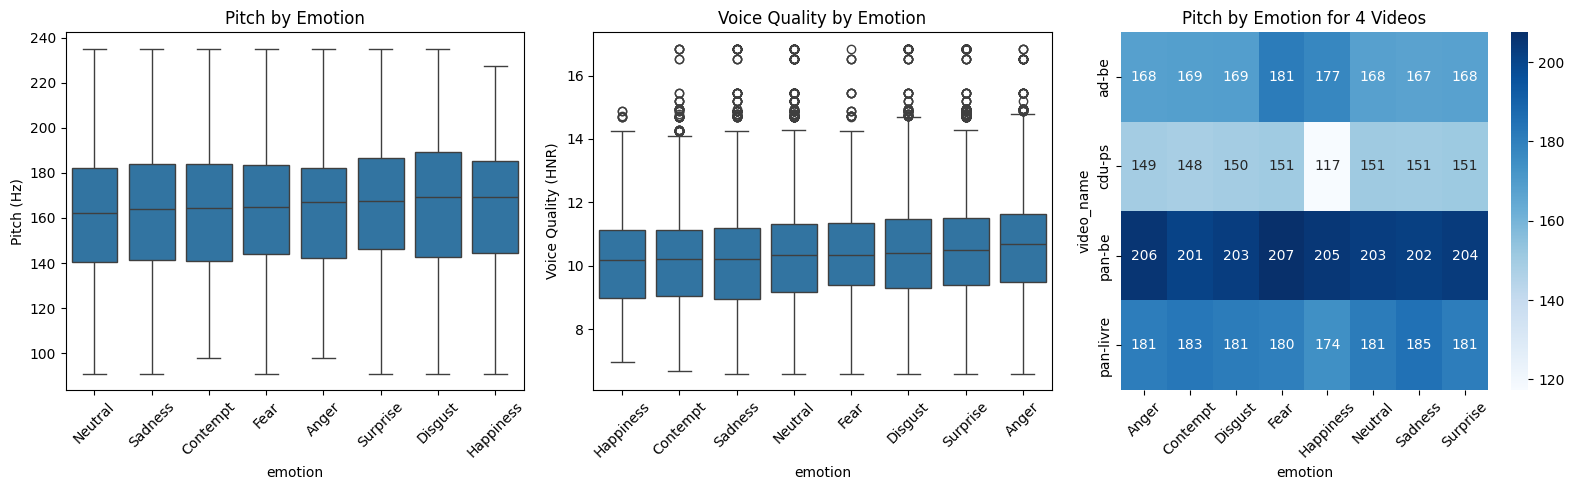

In [ ]:
def show_general_emotions(global_data):
    visual_data = global_data['visual_data']
    audio_data = global_data['audio_data']

    # Match video frames with audio segments
    matched_data = []

    for idx, v_row in visual_data.iterrows():
        video_name = v_row['video_name']
        frame_idx = v_row['original_frame_idx']

        # Find matching audio segment
        video_audio = audio_data[audio_data['video_name'] == video_name]
        for _, a_row in video_audio.iterrows():
            start_time = a_row['time stamp']
            end_time = start_time + a_row['duration']

            if frame_idx >= start_time and frame_idx < end_time:
                if v_row['fer']:
                    for face in v_row['fer']:
                        matched_data.append({
                            'video_name': video_name,
                            'emotion': face['emotion'],
                            'pitch': a_row['meanF0Hz'],
                            'voice_quality': a_row['HNR']
                        })
                break

    matched_df = pd.DataFrame(matched_data)

    # Get emotions with enough data
    emotion_counts = matched_df['emotion'].value_counts()
    common_emotions = emotion_counts[emotion_counts >= 10].index

    # Make 3 plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

    # Plot 1: Pitch by emotion
    plot_data = matched_df[matched_df['emotion'].isin(common_emotions)]
    emotion_order = plot_data.groupby('emotion')['pitch'].median().sort_values().index

    sns.boxplot(x='emotion', y='pitch', data=plot_data, order=emotion_order, ax=ax1)
    ax1.set_title('Pitch by Emotion')
    ax1.set_ylabel('Pitch (Hz)')
    plt.setp(ax1.get_xticklabels(), rotation=45)

    # Plot 2: Voice quality by emotion
    voice_order = plot_data.groupby('emotion')['voice_quality'].median().sort_values().index

    sns.boxplot(x='emotion', y='voice_quality', data=plot_data, order=voice_order, ax=ax2)
    ax2.set_title('Voice Quality by Emotion')
    ax2.set_ylabel('Voice Quality (HNR)')
    plt.setp(ax2.get_xticklabels(), rotation=45)

    # Plot 3: Heatmap for 4 random videos only
    videos = global_data['video_info']
    random_videos = videos.sample(min(4, len(videos)))['video_name'].tolist()

    # Calculate mean pitch by emotion for selected videos
    heatmap_data = matched_df[matched_df['video_name'].isin(random_videos)]
    pitch_by_video = heatmap_data.groupby(['video_name', 'emotion'])['pitch'].mean().reset_index()

    if not pitch_by_video.empty:
        pitch_matrix = pitch_by_video.pivot(index='video_name', columns='emotion', values='pitch')

        # Fill missing values with global mean
        for emotion in pitch_matrix.columns:
            global_mean = matched_df[matched_df['emotion'] == emotion]['pitch'].mean()
            pitch_matrix[emotion].fillna(global_mean, inplace=True)

        sns.heatmap(pitch_matrix, annot=True, fmt='.0f', cmap='Blues', ax=ax3)
        ax3.set_title('Pitch by Emotion for 4 Videos')
        plt.setp(ax3.get_xticklabels(), rotation=45)

    plt.tight_layout()
    return fig

# Show general emotions analysis
general_emotions_fig = show_general_emotions(global_data)
plt.show()

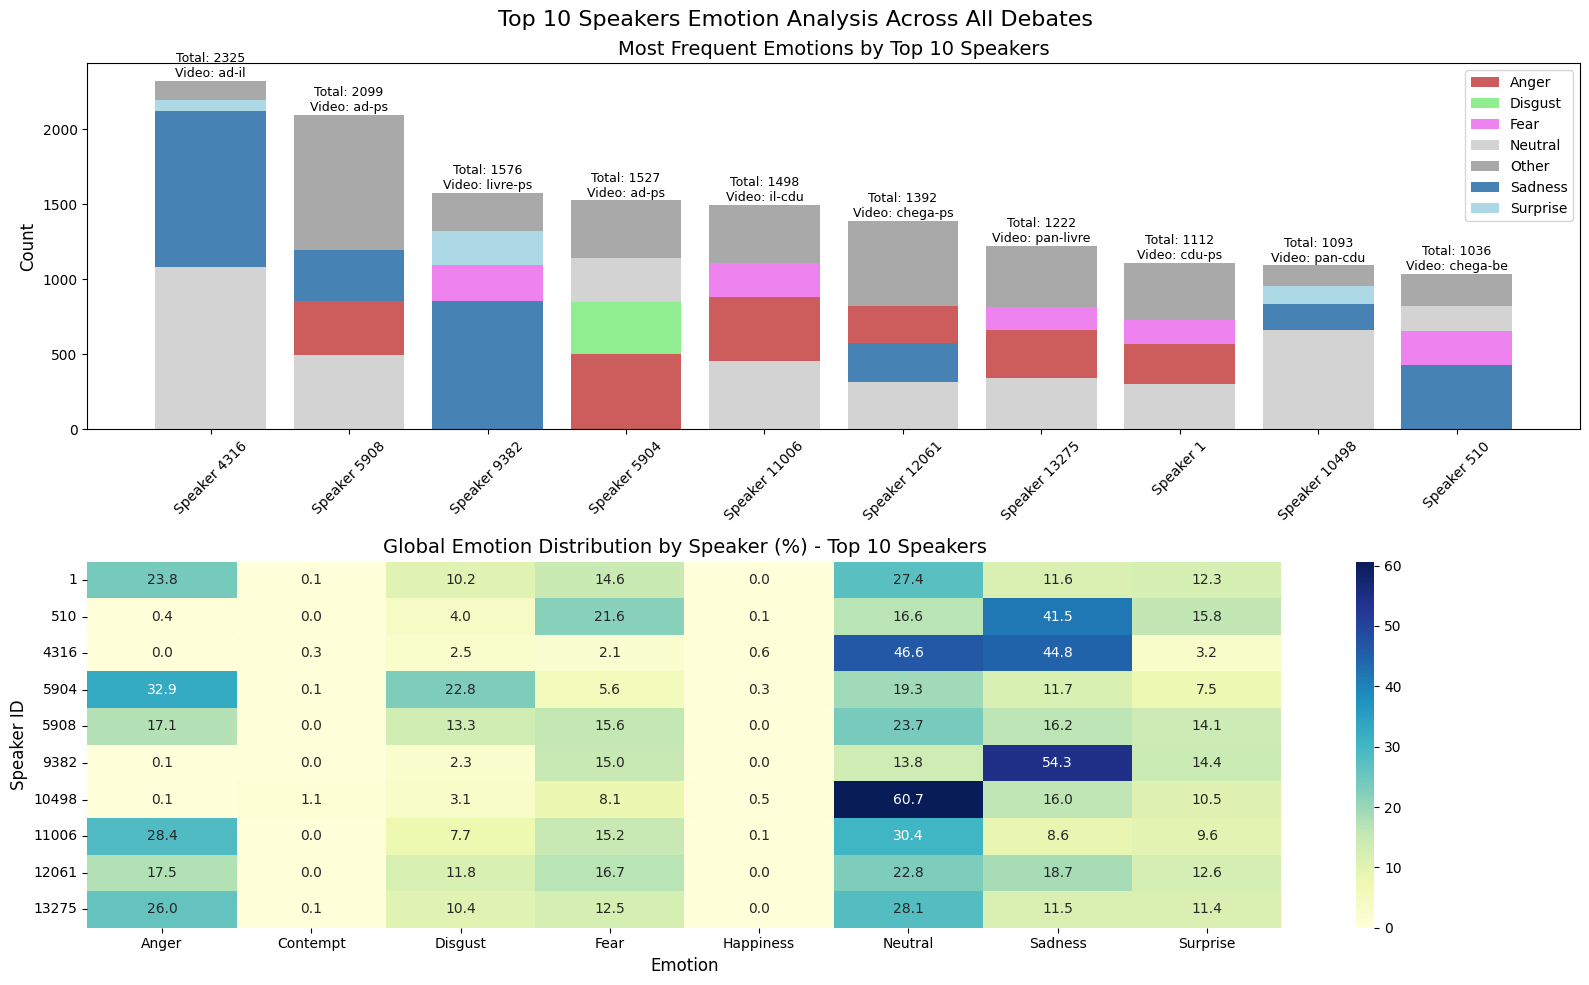

In [ ]:
def create_global_speakers_emotions_slide(global_data):
    """Creates visualization for SPEAKERS AND MOST FREQUENT EMOTION slide
    showing only the top 10 speakers across all videos"""

    visual_data = global_data['visual_data']
    face_clusters = global_data['face_clusters']

    # Analyze emotions by speaker across all videos
    speaker_emotions = []

    for frame_idx, row in visual_data.iterrows():
        if not row['fer'] or frame_idx >= len(face_clusters['face_ids_by_frame']):
            continue

        frame_face_ids = face_clusters['face_ids_by_frame'][frame_idx]

        for i, face in enumerate(row['fer']):
            if i < len(frame_face_ids):
                speaker_id = frame_face_ids[i]
                emotion = face['emotion']
                video_name = row['video_name']

                speaker_emotions.append({
                    'frame_idx': frame_idx,
                    'video_name': video_name,
                    'speaker_id': speaker_id,
                    'emotion': emotion
                })

    speaker_emotions_df = pd.DataFrame(speaker_emotions)

    # Calculate total emotions per speaker for filtering to top 10
    speaker_counts = speaker_emotions_df['speaker_id'].value_counts()

    # Get top 10 speakers by appearance count
    top10_speakers = speaker_counts.nlargest(10).index.tolist()

    # Filter data to include only top 10 speakers
    filtered_emotions_df = speaker_emotions_df[
        speaker_emotions_df['speaker_id'].isin(top10_speakers)]

    # Create figure with 2 panels
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

    # Panel 1: Top emotions by speaker (bar chart)
    ax1 = fig.add_subplot(gs[0, 0])

    # Prepare data for stacked bar chart
    stacked_data = []

    for speaker_id in top10_speakers:
        speaker_data = filtered_emotions_df[filtered_emotions_df['speaker_id'] == speaker_id]
        emotion_counts = speaker_data['emotion'].value_counts()
        total_emotions = len(speaker_data)

        # Get top 3 emotions
        top3 = emotion_counts.head(3)

        # Add "Other" category for remaining emotions
        other_count = total_emotions - sum(top3)

        # Get most common video for this speaker
        video_counts = speaker_data['video_name'].value_counts()
        main_video = video_counts.index[0] if not video_counts.empty else "Unknown"

        stacked_data.append({
            'speaker_id': f"Speaker {speaker_id}",
            'main_video': main_video,
            'top1_emotion': top3.index[0] if len(top3) > 0 else "None",
            'top1_count': top3.values[0] if len(top3) > 0 else 0,
            'top1_pct': (top3.values[0] / total_emotions * 100) if len(top3) > 0 else 0,
            'top2_emotion': top3.index[1] if len(top3) > 1 else "None",
            'top2_count': top3.values[1] if len(top3) > 1 else 0,
            'top2_pct': (top3.values[1] / total_emotions * 100) if len(top3) > 1 else 0,
            'top3_emotion': top3.index[2] if len(top3) > 2 else "None",
            'top3_count': top3.values[2] if len(top3) > 2 else 0,
            'top3_pct': (top3.values[2] / total_emotions * 100) if len(top3) > 2 else 0,
            'other_count': other_count,
            'other_pct': (other_count / total_emotions * 100) if total_emotions > 0 else 0,
            'total': total_emotions
        })

    stacked_df = pd.DataFrame(stacked_data)

    # Sort by total emotions detected
    stacked_df = stacked_df.sort_values('total', ascending=False)

    # Create stacked bar chart
    speakers = stacked_df['speaker_id']

    # Create emotion color map
    emotion_colors = {
        'Neutral': 'lightgray',
        'Happiness': 'gold',
        'Surprise': 'lightblue',
        'Anger': 'indianred',
        'Sadness': 'steelblue',
        'Disgust': 'lightgreen',
        'Fear': 'violet',
        'Contempt': 'tan',
        'None': 'white',
        'Other': 'darkgray'
    }

    # Track all unique emotions for legend
    all_emotions = set()

    # Plot stacked bars
    bottoms = np.zeros(len(speakers))

    # Plot top 3 emotions (without labels on bars)
    for i in range(1, 4):
        emotion_key = f'top{i}_emotion'
        count_key = f'top{i}_count'

        emotions = stacked_df[emotion_key]
        counts = stacked_df[count_key]

        # Track unique emotions for legend
        all_emotions.update(emotions)

        # Map emotions to colors
        colors = [emotion_colors.get(e, 'gray') for e in emotions]

        # Create dictionary mapping emotions to their colors (for legend)
        for emotion in emotions:
            if emotion != 'None' and emotion != 'Other':
                all_emotions.add(emotion)

        # Plot this layer of emotions
        ax1.bar(speakers, counts, bottom=bottoms, color=colors)
        bottoms += counts

    # Add "Other" category
    if stacked_df['other_count'].sum() > 0:
        ax1.bar(speakers, stacked_df['other_count'],
               bottom=bottoms, color='darkgray')
        all_emotions.add('Other')

    # Create custom legend
    legend_patches = []
    for emotion in sorted(all_emotions):
        if emotion != 'None':  # Skip 'None' in legend
            color = emotion_colors.get(emotion, 'gray')
            patch = plt.Rectangle((0, 0), 1, 1, fc=color)
            legend_patches.append((patch, emotion))

    ax1.legend([patch for patch, label in legend_patches],
              [label for patch, label in legend_patches],
              loc='upper right')

    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Most Frequent Emotions by Top 10 Speakers', fontsize=14)
    ax1.tick_params(axis='x', rotation=45)

    # Add total count and main video on top of each bar
    for i, (total, video) in enumerate(zip(stacked_df['total'], stacked_df['main_video'])):
        ax1.text(i, total + 5, f"Total: {total}\nVideo: {video}",
               ha='center', va='bottom', fontsize=9)

    # Panel 2: Speaker-Emotion heat map (only top 10 speakers)
    ax2 = fig.add_subplot(gs[1, 0])

    # Create pivot table for heatmap
    heatmap_data = pd.pivot_table(
        filtered_emotions_df,
        values='frame_idx',
        index=['speaker_id'],
        columns=['emotion'],
        aggfunc='count',
        fill_value=0
    )

    # Convert to percentages
    heatmap_pct = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

    # Plot heatmap
    sns.heatmap(heatmap_pct, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax2)

    ax2.set_xlabel('Emotion', fontsize=12)
    ax2.set_ylabel('Speaker ID', fontsize=12)
    ax2.set_title('Global Emotion Distribution by Speaker (%) - Top 10 Speakers', fontsize=14)

    plt.suptitle('Top 10 Speakers Emotion Analysis Across All Debates', fontsize=16, y=0.98)
    plt.tight_layout()

    return fig

global_speakers_slide = create_global_speakers_emotions_slide(global_data)
plt.show()

Top 10 speakers appear in: [2325, 2099, 1576, 1527, 1498, 1392, 1222, 1112, 1093, 1036] frames


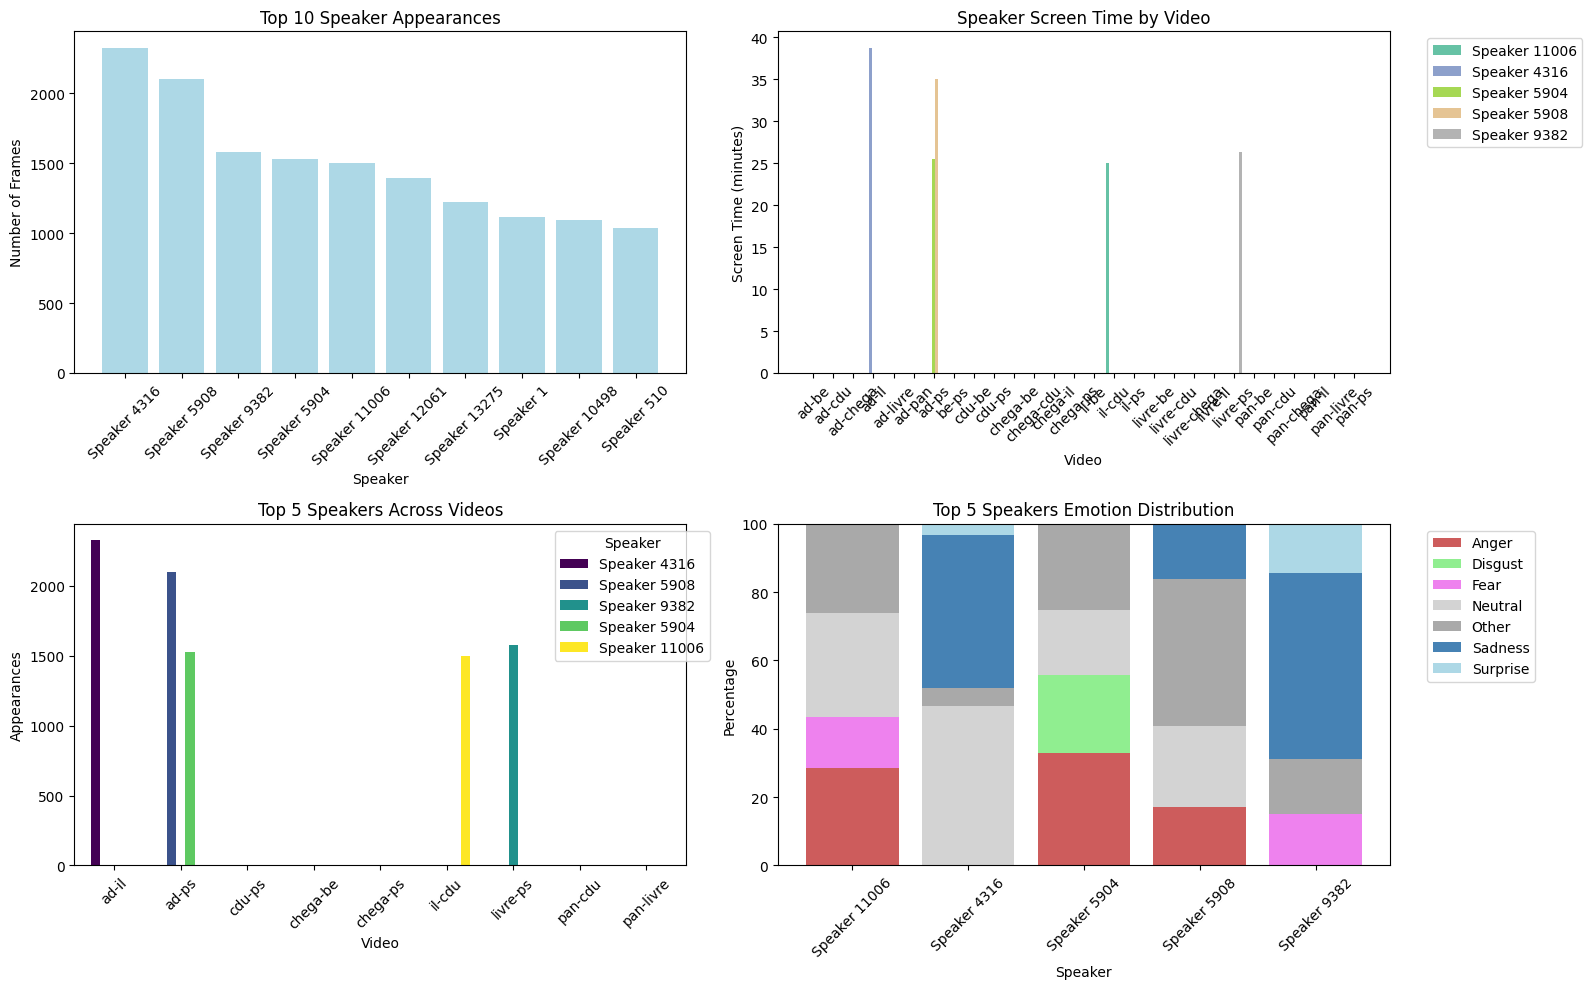

In [ ]:
def analyze_top_speakers(global_data):
    visual_data = global_data['visual_data']
    face_clusters = global_data['face_clusters']

    # Count how many times each speaker appears
    speaker_counts = {}
    for frame_faces in face_clusters['face_ids_by_frame']:
        for speaker_id in frame_faces:
            speaker_counts[speaker_id] = speaker_counts.get(speaker_id, 0) + 1

    # Get top 10 speakers
    top_speakers = sorted(speaker_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    top_speaker_ids = [speaker[0] for speaker in top_speakers]

    print(f"Top 10 speakers appear in: {[count for _, count in top_speakers]} frames")

    # Collect data for top speakers with emotions
    speaker_data = []
    for idx, row in visual_data.iterrows():
        if idx >= len(face_clusters['face_ids_by_frame']):
            continue

        frame_faces = face_clusters['face_ids_by_frame'][idx]

        if row['fer'] and frame_faces:
            for i, face in enumerate(row['fer']):
                if i < len(frame_faces) and frame_faces[i] in top_speaker_ids:
                    speaker_data.append({
                        'speaker_id': frame_faces[i],
                        'video': row['video_name'],
                        'emotion': face['emotion'],
                        'frame_idx': idx
                    })

    speaker_df = pd.DataFrame(speaker_data)

    # Make 4 plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

    # Plot 1: Speaker appearance frequency
    speaker_ids = [f"Speaker {s}" for s, _ in top_speakers]
    appearance_counts = [count for _, count in top_speakers]

    ax1.bar(speaker_ids, appearance_counts, color='lightblue')
    ax1.set_title('Top 10 Speaker Appearances')
    ax1.set_ylabel('Number of Frames')
    ax1.set_xlabel('Speaker')
    plt.setp(ax1.get_xticklabels(), rotation=45)

    # Plot 2: Speaker screen time comparison
    if not speaker_df.empty:
        top5_speakers = top_speaker_ids[:5]

        # Calculate screen time for each speaker across videos
        speaker_screentime = []
        videos = global_data['video_info']['video_name'].unique()

        for video in videos:
            video_data = speaker_df[speaker_df['video'] == video]
            for speaker_id in top5_speakers:
                speaker_frames = video_data[video_data['speaker_id'] == speaker_id]
                screen_time = len(speaker_frames) / 60  # convert to minutes (assuming 1fps)

                speaker_screentime.append({
                    'video': video,
                    'speaker': f'Speaker {speaker_id}',
                    'screen_time': screen_time
                })

        screentime_df = pd.DataFrame(speaker_screentime)
        pivot_screentime = screentime_df.pivot(index='video', columns='speaker', values='screen_time').fillna(0)

        # Create grouped bar chart
        x = np.arange(len(pivot_screentime.index))
        width = 0.15
        colors = plt.cm.Set2(np.linspace(0, 1, len(pivot_screentime.columns)))

        for i, speaker in enumerate(pivot_screentime.columns):
            ax2.bar(x + i * width, pivot_screentime[speaker], width,
                   label=speaker, color=colors[i])

        ax2.set_title('Speaker Screen Time by Video')
        ax2.set_ylabel('Screen Time (minutes)')
        ax2.set_xlabel('Video')
        ax2.set_xticks(x + width * 2)
        ax2.set_xticklabels(pivot_screentime.index, rotation=45)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot 3: Speaker distribution across videos
    if not speaker_df.empty:
        video_speaker_counts = speaker_df.groupby(['video', 'speaker_id']).size().unstack(fill_value=0)
        video_speaker_counts.columns = [f"Speaker {i}" for i in video_speaker_counts.columns]

        # Show only top 5 speakers for clarity
        top5_speaker_names = [f"Speaker {i}" for i in top5_speakers]
        available_speakers = [s for s in top5_speaker_names if s in video_speaker_counts.columns]

        if available_speakers:
            video_speaker_counts[available_speakers].plot(kind='bar', ax=ax3,
                                                         width=0.7, colormap='viridis')
            ax3.set_title('Top 5 Speakers Across Videos')
            ax3.set_ylabel('Appearances')
            ax3.set_xlabel('Video')
            ax3.legend(title='Speaker', bbox_to_anchor=(1.05, 1))
            plt.setp(ax3.get_xticklabels(), rotation=45)


    # Plot 4: Top 5 Speakers Across Videos (new addition)
    if not speaker_df.empty:
        top5_speakers = top_speaker_ids[:5]

        # Calculate speaker emotions across all videos
        speaker_emotion_data = []
        for speaker_id in top5_speakers:
            speaker_data_filtered = speaker_df[speaker_df['speaker_id'] == speaker_id]
            emotion_counts = speaker_data_filtered['emotion'].value_counts()
            total_emotions = len(speaker_data_filtered)

            # Get top 3 emotions for this speaker
            top3_emotions = emotion_counts.head(3)
            other_count = total_emotions - sum(top3_emotions.values)

            for i, (emotion, count) in enumerate(top3_emotions.items()):
                speaker_emotion_data.append({
                    'speaker': f'Speaker {speaker_id}',
                    'emotion': emotion,
                    'count': count,
                    'percentage': (count / total_emotions) * 100
                })

            if other_count > 0:
                speaker_emotion_data.append({
                    'speaker': f'Speaker {speaker_id}',
                    'emotion': 'Other',
                    'count': other_count,
                    'percentage': (other_count / total_emotions) * 100
                })

        # Create stacked bar chart
        emotion_df = pd.DataFrame(speaker_emotion_data)
        pivot_emotions = emotion_df.pivot(index='speaker', columns='emotion', values='percentage').fillna(0)

        # Color map for emotions
        emotion_colors = {'Neutral': 'lightgray', 'Happiness': 'gold', 'Surprise': 'lightblue',
                         'Anger': 'indianred', 'Sadness': 'steelblue', 'Fear': 'violet',
                         'Disgust': 'lightgreen', 'Contempt': 'tan', 'Other': 'darkgray'}

        bottom = np.zeros(len(pivot_emotions))
        for emotion in pivot_emotions.columns:
            color = emotion_colors.get(emotion, 'gray')
            ax4.bar(range(len(pivot_emotions)), pivot_emotions[emotion],
                   bottom=bottom, label=emotion, color=color)
            bottom += pivot_emotions[emotion]

        ax4.set_title('Top 5 Speakers Emotion Distribution')
        ax4.set_ylabel('Percentage')
        ax4.set_xlabel('Speaker')
        ax4.set_xticks(range(len(pivot_emotions)))
        ax4.set_xticklabels(pivot_emotions.index, rotation=45)
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return fig

# Analyze top speakers
speakers_fig = analyze_top_speakers(global_data)
plt.show()

Top 10 speakers appear in: [2325, 2099, 1576, 1527, 1498, 1392, 1222, 1112, 1093, 1036] frames


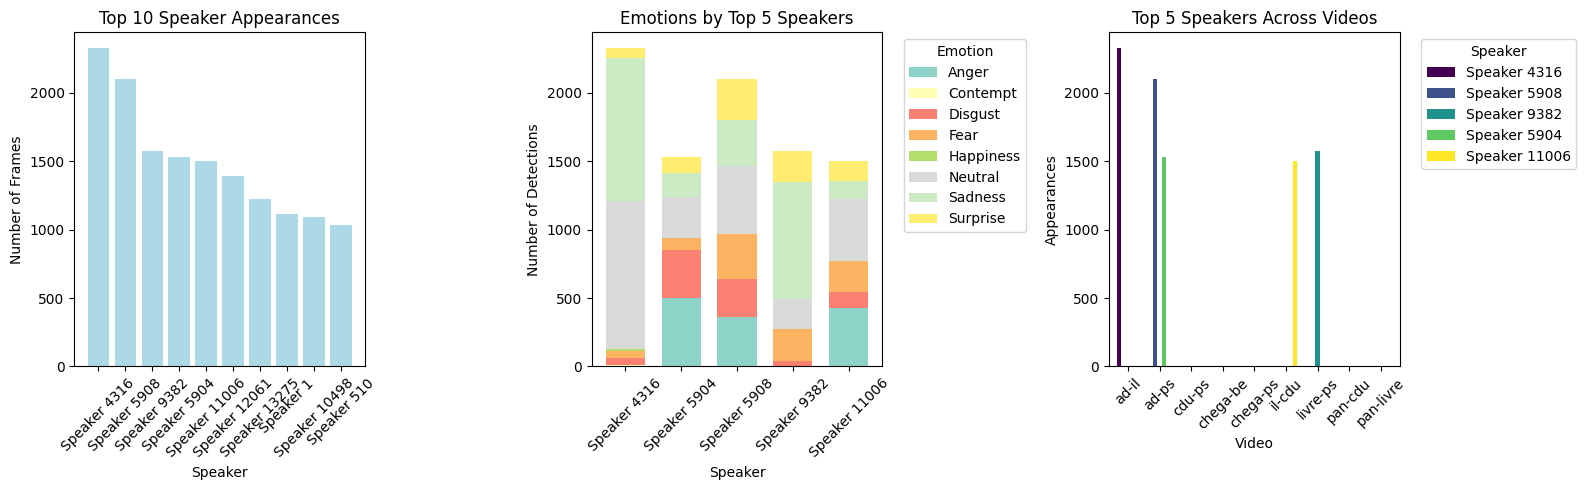

In [ ]:
def analyze_top_speakers(global_data):
    visual_data = global_data['visual_data']
    face_clusters = global_data['face_clusters']

    # Count how many times each speaker appears
    speaker_counts = {}
    for frame_faces in face_clusters['face_ids_by_frame']:
        for speaker_id in frame_faces:
            speaker_counts[speaker_id] = speaker_counts.get(speaker_id, 0) + 1

    # Get top 10 speakers
    top_speakers = sorted(speaker_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    top_speaker_ids = [speaker[0] for speaker in top_speakers]

    print(f"Top 10 speakers appear in: {[count for _, count in top_speakers]} frames")

    # Collect data for top speakers
    speaker_data = []
    for idx, row in visual_data.iterrows():
        frame_faces = face_clusters['face_ids_by_frame'][idx]

        if row['fer'] and frame_faces:
            for i, face in enumerate(row['fer']):
                if i < len(frame_faces) and frame_faces[i] in top_speaker_ids:
                    speaker_data.append({
                        'speaker_id': frame_faces[i],
                        'video': row['video_name'],
                        'emotion': face['emotion'],
                        'frame_idx': idx
                    })

    speaker_df = pd.DataFrame(speaker_data)

    # Make 3 plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

    # Plot 1: Speaker appearance frequency
    speaker_ids = [f"Speaker {s}" for s, _ in top_speakers]
    appearance_counts = [count for _, count in top_speakers]

    ax1.bar(speaker_ids, appearance_counts, color='lightblue')
    ax1.set_title('Top 10 Speaker Appearances')
    ax1.set_ylabel('Number of Frames')
    ax1.set_xlabel('Speaker')
    plt.setp(ax1.get_xticklabels(), rotation=45)

    # Plot 2: Emotions by top 5 speakers
    if not speaker_df.empty:
        top5_speakers = top_speaker_ids[:5]
        top5_data = speaker_df[speaker_df['speaker_id'].isin(top5_speakers)]

        emotion_by_speaker = top5_data.groupby(['speaker_id', 'emotion']).size().unstack(fill_value=0)
        emotion_by_speaker.index = [f"Speaker {i}" for i in emotion_by_speaker.index]

        emotion_by_speaker.plot(kind='bar', stacked=True, ax=ax2,
                               colormap='Set3', width=0.7)
        ax2.set_title('Emotions by Top 5 Speakers')
        ax2.set_ylabel('Number of Detections')
        ax2.set_xlabel('Speaker')
        ax2.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
        plt.setp(ax2.get_xticklabels(), rotation=45)

    # Plot 3: Speaker distribution across videos
    if not speaker_df.empty:
        video_speaker_counts = speaker_df.groupby(['video', 'speaker_id']).size().unstack(fill_value=0)
        video_speaker_counts.columns = [f"Speaker {i}" for i in video_speaker_counts.columns]

        # Show only top 5 speakers for clarity
        top5_speaker_names = [f"Speaker {i}" for i in top5_speakers]
        available_speakers = [s for s in top5_speaker_names if s in video_speaker_counts.columns]

        if available_speakers:
            video_speaker_counts[available_speakers].plot(kind='bar', ax=ax3,
                                                         width=0.7, colormap='viridis')
            ax3.set_title('Top 5 Speakers Across Videos')
            ax3.set_ylabel('Appearances')
            ax3.set_xlabel('Video')
            ax3.legend(title='Speaker', bbox_to_anchor=(1.05, 1))
            plt.setp(ax3.get_xticklabels(), rotation=45)

    plt.tight_layout()
    return fig

# Analyze top speakers
speakers_fig = analyze_top_speakers(global_data)
plt.show()

PART 2